## Imports

In [1]:
# libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# local modules
from spambase.column_names import columns_spambase ## columns_spambase is a list created in the Path("\spambase\column_names.py") i.e. the list of column names

# preprocessing
from sklearn.model_selection import train_test_split, learning_curve

# pipelines
from sklearn.pipeline import make_pipeline

# models
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import root_mean_squared_error as rmse


# custom modules for debugging ## Look for the repo
from my_debuggers import nan_detector, create_clf_plots # custom modules


### Importing the dataset

In [2]:
spambase = pd.read_csv(Path(r'spambase\spambase.data'), names=columns_spambase, index_col=False)

## Preprocessing

### Getting Insights from the Dataset

In [3]:
spambase.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
nan_detector(spambase) ## using custom module to detect NaN values

Count of columns having NaN values = 0
Null values containing Columns = []


In [5]:
# spambase.isna().sum() ## the custom module works perfectly

In [6]:
spambase.info()
spambase.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_"will             4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

(4601, 58)

### Splitting the Features and Target

In [7]:
target = spambase["Class"] ## (4601,1)
features = spambase.drop("Class", axis=1) ## (4601, 57)

### Finding correlation between features

In [8]:
corr_matrix = features.corr().abs()
np.fill_diagonal(corr_matrix.values, 0)

max_corr = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
 
max_corr[max_corr > 0.85]
## only one pair of highly correlated feature 
## ("word_freq_144" and "word_freq_857"); corr = 0.996
## we wont drop it as tree based models arent affected by multicollinearity

word_freq_415  word_freq_857    0.996066
dtype: float64

### Splitting the dataset into the Training, Validation and Test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42) ## 90% training and 10% testing

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=43) ## 80% training and 20% validation


In [11]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3312, 57), (3312,), (828, 57), (828,), (461, 57), (461,))

#### Keeping the target sets in the DataFrame format

In [12]:
y_train_df, y_val_df, y_test_df = y_train, y_val, y_test

#### Converting the target sets into 1D numpy arrays

In [13]:
# tree based models works better with numerical data,
# so we need to convert the Dataframe to numerical data

training_set = [y_train, y_val, y_test]
train_set_ndarray = []
for i in training_set:
    i = i.to_numpy().ravel()
    train_set_ndarray.append(i)

y_train, y_val, y_test = train_set_ndarray
# type(X_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3312, 57), (3312,), (828, 57), (828,), (461, 57), (461,))

## Defining Functions for Model Evaluation

#### Confusion Matrix

In [14]:
def plot_confusion_matrix(cm, ax=None):
    """
    Plots a confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'], ax=ax)
    
    if ax==None:
        plt.show()
    else:
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')
    

#### Learning Curve

In [15]:
def plot_learning_curve(estimator, X, y, cv=5, ax=None, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs:int = -1):
    """
    Plots the learning curve of a model using matplotlib.pyplot
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate errors
    train_scores_ = train_mean
    val_scores_ = val_mean

    # Plot the learning curve
    plt.figure(figsize=(4,3))
    ax.plot(train_sizes, train_scores_, 'o-', label='Training Score')
    ax.fill_between(train_sizes, train_scores_ - train_std, train_scores_ + train_std, alpha=0.1)

    ax.plot(train_sizes, val_scores_, 'o-', label='Validation Score')
    ax.fill_between(train_sizes, val_scores_ - val_std, val_scores_ + val_std, alpha=0.1)

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel(scoring.capitalize())
    ax.set_title('Learning Curve')
    ax.legend(loc='best')
    ax.grid()

### Model Evaluation plot

In [16]:
def plot_model_evaluation(model, cm, n_row:int, n_col:int, n_jobs:int=-1): 
    """
    Plots the confusion matrix and learning curve of a model
    """
    fig, axs = plt.subplots(n_row ,n_col, figsize=(10,4))
    plot_confusion_matrix(cm,ax=axs[0])
    plot_learning_curve(model, X_train.to_numpy(), y_train, ax=axs[1], n_jobs=n_jobs)
    plt.tight_layout()

## Training the Classifier Models

**Defining CV Strategy**

In [17]:
cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

#### Cross Validation

In [18]:
params_linreg = {
    'C': np.logspace(-4, 4, 30),
    'max_iter': [100, 200, 300],
    'solver': ['liblinear'],
}

logreg_cv = RandomizedSearchCV(
    
    estimator=LogisticRegression(random_state=42),     
    param_distributions=params_linreg, 
    n_iter=80, cv=cv_kfold, 
    verbose=0, n_jobs=-1, random_state=42)

logreg_cv.fit(X_train, y_train_df) 

print(f'Best Parameters = {logreg_cv.best_params_}')

print(f'\nBest Training score = {logreg_cv.best_score_}') # 92.8140%
print(f'Best Validation score = {logreg_cv.score(X_val, y_val)}') # 92.8744%

Best Parameters = {'solver': 'liblinear', 'max_iter': 300, 'C': np.float64(1.3738237958832638)}

Best Training score = 0.9281399661886599
Best Validation score = 0.928743961352657


#### Fitting the model into the training set

In [19]:
logreg_clf = LogisticRegression(C=1.37, solver='liblinear')
logreg_clf.fit(X_train, y_train)

logreg_train_score = logreg_clf.score(X_train, y_train)
logreg_val_score = logreg_clf.score(X_val, y_val)

print(f'Training Accuracy: {logreg_train_score}') # 93.1159%
print(f'Validation Accuracy: {logreg_val_score}') # 92.9952% 

Training Accuracy: 0.9311594202898551
Validation Accuracy: 0.9299516908212561


#### Plotting the Confusion matrix and Learnig curve

In [20]:
y_val_pred_lr = logreg_clf.predict(X_val)
cm = confusion_matrix(y_val,y_val_pred_lr)

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
# plot_confusion_matrix(cm,ax=axs[0])

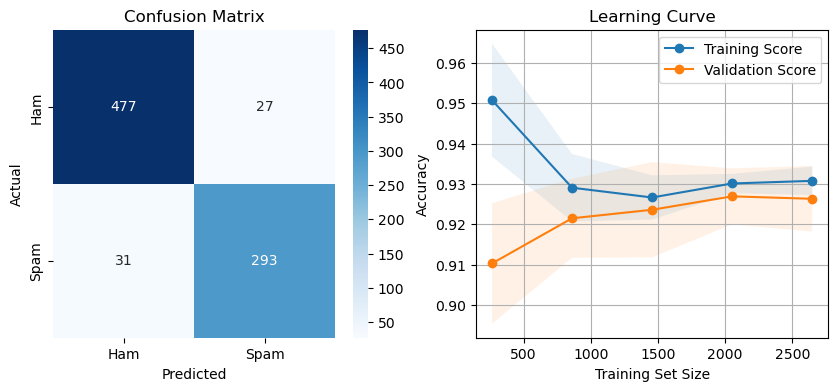

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [21]:
plot_model_evaluation(logreg_clf, cm, n_row=1, n_col=2) # We have pre-defined this function to plot the confusion matrix and the learning curve in less code.

# fig, axs = plt.subplots(1,2, figsize=(10,4))
# plot_confusion_matrix(cm,ax=axs[0])
# plot_learning_curve(logreg_clf, X_train, y_train, ax=axs[1])
# plt.tight_layout()

#### Classification Report

In [22]:
pd.DataFrame(classification_report(y_val, y_val_pred_lr, target_names=["ham", "spam"], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.938976,0.946429,0.942688,504.000000
spam,0.915625,0.904321,0.909938,324.000000
accuracy,0.929952,0.929952,0.929952,0.929952
macro avg,0.927301,0.925375,0.926313,828.000000
weighted avg,0.929839,0.929952,0.929873,828.000000


### Decision Tree Classifier

#### Cross Validation

In [23]:
param_dist_tree = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': np.arange(2, 51, 2),
    'min_samples_leaf': np.arange(1, 51, 2),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [10, 20, 30, 50, None],
    'criterion': ['gini', 'entropy']
}

tree_cv = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_tree,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1)

tree_cv.fit(X_train, y_train) 

print(f'Best Parameters = {tree_cv.best_params_}')

print(f'\nBest Training score = {tree_cv.best_score_}') # 90.2480%
print(f'Best Validation score = {tree_cv.score(X_val, y_val)}') # 93.3575%

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters = {'min_samples_split': np.int64(50), 'min_samples_leaf': np.int64(13), 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}

Best Training score = 0.902479802053287
Best Validation score = 0.9335748792270532


#### Fitting the model into the training set

In [24]:
# tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=5, random_state=42)

tree_clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=10, 
    min_samples_leaf=30,  
    max_features="sqrt",  
    max_leaf_nodes=30,     
    criterion='entropy',  
    random_state=42)

tree_clf.fit(X_train, y_train) 

print(f'Training score = {tree_cv.score(X_train, y_train)}') # 92.8744%
print(f'Validation score = {tree_cv.score(X_val, y_val)}') # 93.3575%

Training score = 0.928743961352657
Validation score = 0.9335748792270532


#### Plotting the Model Evaluation plots

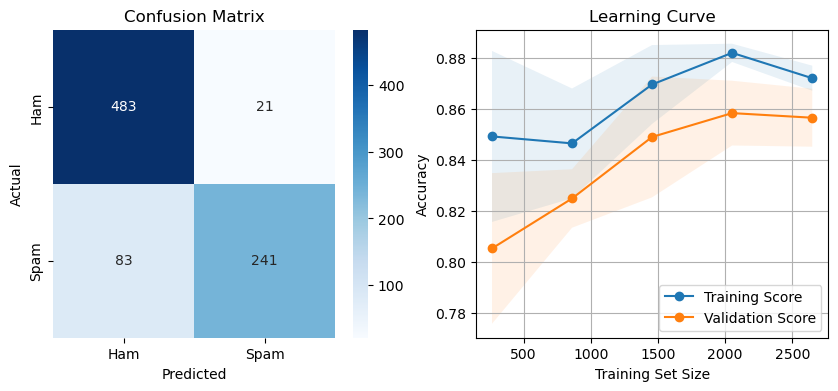

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [25]:
y_val_pred_tree = tree_clf.predict(X_val)
cm = confusion_matrix(y_val,y_val_pred_tree)

plot_model_evaluation(tree_clf, cm, n_row=1, n_col=2) # we reject the decision tree model, as its overfitting pretty badly

#### Classification Report

In [26]:
pd.DataFrame(classification_report(y_val, y_val_pred_tree, target_names=["ham", "spam"], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.853357,0.958333,0.902804,504.000000
spam,0.919847,0.743827,0.822526,324.000000
accuracy,0.874396,0.874396,0.874396,0.874396
macro avg,0.886602,0.851080,0.862665,828.000000
weighted avg,0.879375,0.874396,0.871391,828.000000


## Using Ensemble Models

### Random Forest Classifier

#### Cross Validation

In [27]:
params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

cv_stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=params_rf, n_iter=10, cv=cv_stratified_kfold, verbose=1, n_jobs=-1)

rf_cv.fit(X_train, y_train)
print(f'Best Parameters = {rf_cv.best_params_}')
print(f'\nBest Training score = {rf_cv.best_score_}')
print(f'Best Validation score = {rf_cv.score(X_val, y_val)}')
print(f'\nValidation RMSE = {rmse(y_val, rf_cv.predict(X_val))}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters = {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}

Best Training score = 0.95048461401758
Best Validation score = 0.967391304347826

Validation RMSE = 0.1805787796286538


#### Fitting the model into the training set

In [28]:
# # Using a simpler RandomForestClassifier
# rf_clf = RandomForestClassifier(
#     n_estimators=100, min_samples_split=20, min_samples_leaf=10, max_features="sqrt", 
#     max_depth=10, bootstrap=True, criterion='entropy', random_state=42)


# # Using the best parameters from the RandomizedSearchCV
# rf_clf = RandomForestClassifier(
#     min_samples_split=50, max_depth=8,
#     bootstrap=True, criterion='entropy',
#     max_features='log2', n_estimators=500, random_state=42)

# # More aggressive regularization
rf_clf = RandomForestClassifier(
    n_estimators=100,      # Equal number of trees
    max_depth=8,           # Shallower trees
    min_samples_split=50,  # Higher threshold for splitting
    min_samples_leaf=30,   # More samples required in leaf nodes
    max_features="sqrt",   # Use "sqrt" for feature selection
    max_leaf_nodes=30,     # Limit number of leaf nodes
    random_state=42)


rf_clf.fit(X_train, y_train)

print(f'Training score = {rf_clf.score(X_train, y_train)}') # 93.1763%
print(f'Validation score = {rf_clf.score(X_val, y_val)}') # 94.2029%
print(f'\nValidation RMSE = {rmse(y_val, rf_clf.predict(X_val))}') # 0.2408

Training score = 0.9317632850241546
Validation score = 0.9420289855072463

Validation RMSE = 0.2407717061715384


#### Plotting the model evaluation plots

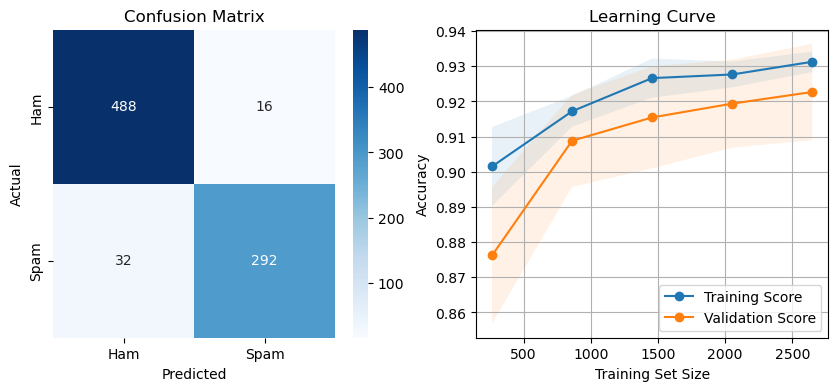

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [29]:
y_val_pred_rf = rf_clf.predict(X_val)
cm = confusion_matrix(y_val,y_val_pred_rf)

plot_model_evaluation(rf_clf, cm, 1, 2)

#### Classification Report

In [30]:
pd.DataFrame(classification_report(y_val, y_val_pred_rf, target_names=["ham", "spam"], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.938462,0.968254,0.953125,504.000000
spam,0.948052,0.901235,0.924051,324.000000
accuracy,0.942029,0.942029,0.942029,0.942029
macro avg,0.943257,0.934744,0.938588,828.000000
weighted avg,0.942214,0.942029,0.941748,828.000000


### XGBoost Classifier

#### Fitting the model into the training set

In [31]:
xgb_clf = XGBClassifier(
    learning_rate=0.01, gamma=0.1, max_depth=7, n_estimators=450, seed=42)

xgb_clf.fit(X_train.to_numpy(), y_train) # xgboost clf works with np array

print(f'Training score = {xgb_clf.score(X_train.to_numpy(), y_train)}') # 97.6147%
print(f'Validation score = {xgb_clf.score(X_val.to_numpy(), y_val)}') # 95.8937%

Training score = 0.976147342995169
Validation score = 0.9589371980676329


#### Ploting the model evaluation plots

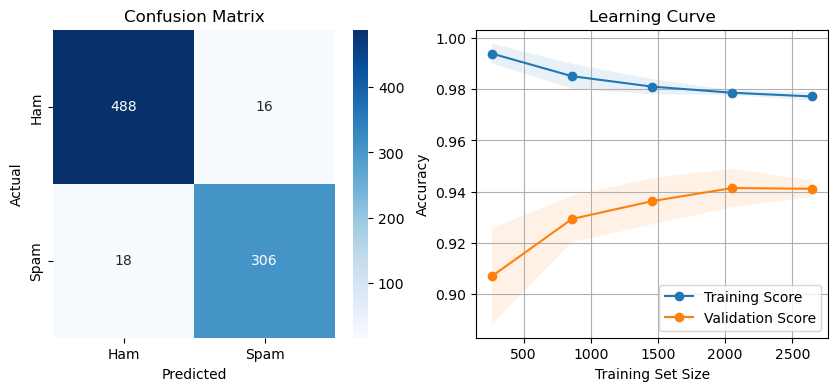

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [32]:
y_val_pred_xgb = xgb_clf.predict(X_val.to_numpy())
cm = confusion_matrix(y_val, y_val_pred_xgb)
plot_model_evaluation(xgb_clf, cm, 1, 2, n_jobs=3)

#### Classification Report

In [33]:
pd.DataFrame(classification_report(y_val, y_val_pred_xgb, target_names=["ham", "spam"], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.964427,0.968254,0.966337,504.000000
spam,0.950311,0.944444,0.947368,324.000000
accuracy,0.958937,0.958937,0.958937,0.958937
macro avg,0.957369,0.956349,0.956853,828.000000
weighted avg,0.958903,0.958937,0.958914,828.000000


### Gradient Boosting Classifier

#### Cross Validation

In [34]:
param_dist_grad = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': np.linspace(0.1, 1.0, num=10),
    'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': np.linspace(50, 500, num=10, dtype=int),
    'subsample': np.linspace(0.01, 1.00, num=10),
    # 'tol': [0.001, 0.0001]
}

grad_cv = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_distributions=param_dist_grad, cv=cv_stratified_kfold, 
    n_iter=10, n_jobs=-1, random_state=42)

grad_cv.fit(X_train.to_numpy(), y_train)

print(f'Best Parameters = {grad_cv.best_params_}')

print(f'\nBest Training score = {grad_cv.best_score_}') # 94.8974%
print(f'Best Validation score = {grad_cv.score(X_val.to_numpy(), y_val)}') # 96.1353%

print(f'\nValidation RMSE = {rmse(y_val, grad_cv.predict(X_val.to_numpy()))}') # 0.1966

Best Parameters = {'subsample': np.float64(1.0), 'n_estimators': np.int64(350), 'loss': 'exponential', 'learning_rate': np.float64(0.1), 'criterion': 'squared_error'}

Best Training score = 0.9489740399994531
Best Validation score = 0.961352657004831

Validation RMSE = 0.19658927487319616


#### Fitting the model into the training set

In [35]:
grad_clf = GradientBoostingClassifier(n_estimators=250, criterion='friedman_mse', loss='exponential', learning_rate=0.1, subsample=0.6, random_state=42)

grad_clf.fit(X_train.to_numpy(), y_train)

print(f'\nTraining score = {grad_clf.score(X_train.to_numpy(), y_train)}') # 97.1316%
print(f'Validation score = {grad_clf.score(X_val.to_numpy(), y_val)}') # 95.6522%

y_val_pred_grad = grad_clf.predict(X_val.to_numpy())
print(f'\nRMSE = {rmse(y_val, y_val_pred_grad)}') # 0.2085


Training score = 0.971316425120773
Validation score = 0.9565217391304348

RMSE = 0.20851441405707477


#### Plotting the model evaluation plots

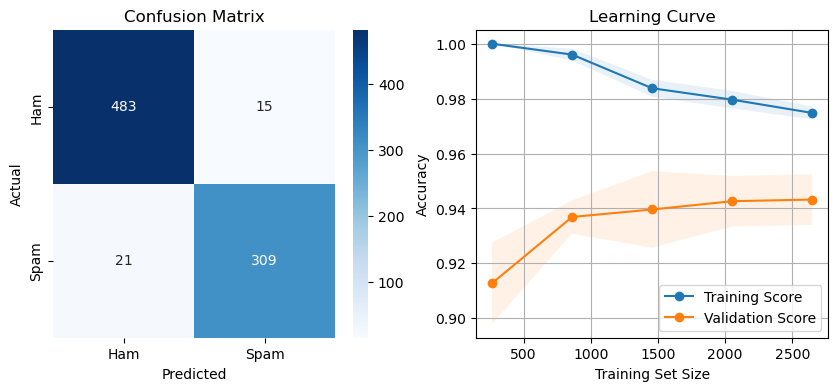

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [36]:
cm=confusion_matrix(y_val_pred_grad, y_val)

plot_model_evaluation(grad_clf, cm, 1, 2)

#### Classification Report

In [37]:
pd.DataFrame(classification_report(y_val, y_val_pred_grad, target_names=['ham', 'spam'], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.969880,0.958333,0.964072,504.000000
spam,0.936364,0.953704,0.944954,324.000000
accuracy,0.956522,0.956522,0.956522,0.956522
macro avg,0.953122,0.956019,0.954513,828.000000
weighted avg,0.956765,0.956522,0.956591,828.000000


### Voting Classifier

#### Fitting the model into the training set

In [38]:
vote_clf = VotingClassifier(
    estimators=[
        ('logreg_clf', logreg_clf), 
        ('rf_clf', rf_clf), 
        ('xgb_clf', xgb_clf),
        ('grad_clf', grad_clf)
        ]
)

vote_clf.fit(X_train.to_numpy(), y_train)
print(f'Voting clf Training Score: {vote_clf.score(X_train.to_numpy(), y_train)}') # 95.6220%
print(f'Voting clf Validation Score: {vote_clf.score(X_val.to_numpy(), y_val)}') # 95.8937%

Voting clf Training Score: 0.956219806763285
Voting clf Validation Score: 0.9589371980676329


#### Ploting the model evaluation plots 

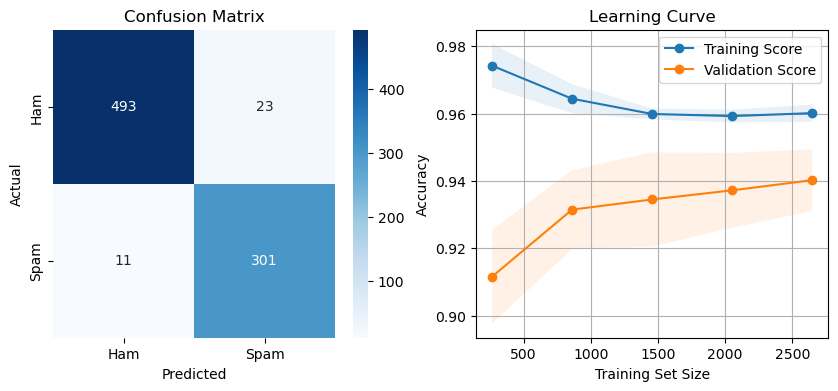

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [39]:
y_val_pred_vote = vote_clf.predict(X_val.to_numpy())
cm= confusion_matrix(y_val_pred_vote, y_val)

plot_model_evaluation(vote_clf, cm, 1, 2, n_jobs=2)
# classification_report(y_val, y_val_pred_vote)

#### Classification Report

In [40]:
pd.DataFrame(classification_report(y_val, y_val_pred_vote, target_names=['ham', 'spam'], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.955426,0.978175,0.966667,504.000000
spam,0.964744,0.929012,0.946541,324.000000
accuracy,0.958937,0.958937,0.958937,0.958937
macro avg,0.960085,0.953593,0.956604,828.000000
weighted avg,0.959072,0.958937,0.958791,828.000000


## Using Stacking Ensemble with Voting Classifier for the Best Performance

In [41]:
stack_estimators = [ 
    # ('logreg_clf', logreg_clf),
    # ('rf_clf', rf_clf),
    ('xgb_clf', xgb_clf),
    ('vote_clf', vote_clf),
    ('grad_clf', grad_clf)
]
# Discarded Random Forest and Logistic Regression as these are performing the worst
# Random Forest Classifier is overfitting the training set

#### stack_clf_lr (Logistic Regression)

In [42]:
stack_clf_lr = StackingClassifier(
    
    estimators=stack_estimators, 

    final_estimator=LogisticRegression(random_state=40)
    )

stack_clf_lr.fit(X_train.to_numpy(), y_train)

print(f'Train Score = {stack_clf_lr.score(X_train.to_numpy(), y_train):.5f} | ', end='') # 0.97675
print(f'Validation Score = {stack_clf_lr.score(X_val.to_numpy(), y_val):.5f}') # 0.95531

Train Score = 0.97675 | Validation Score = 0.95531


### Using Voting Classifier with `stack_clf_lr`

In [43]:
vote_clf_stack = VotingClassifier(
    estimators=[
        ('stack_clf_lr', stack_clf_lr),
        ('xgb', xgb_clf),
        ('vote_clf', vote_clf),
        ('grad_clf', grad_clf),
        # ('rf_clf', rf_clf)
    ])

vote_clf_stack.fit(X_train.to_numpy(), y_train)

print(f'Voting clf Training Score: {vote_clf_stack.score(X_train.to_numpy(), y_train)}') # 97.1920%
print(f'Voting clf Validation Score: {vote_clf_stack.score(X_val.to_numpy(), y_val)}') # 96.3768%

Voting clf Training Score: 0.9719202898550725
Voting clf Validation Score: 0.9637681159420289


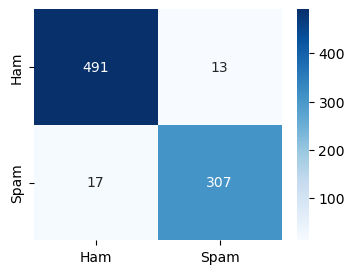

In [44]:
y_val_pred_stack = vote_clf_stack.predict(X_val.to_numpy())
cm = confusion_matrix(y_val, y_val_pred_stack)

plot_confusion_matrix(cm)

In [45]:
pd.DataFrame(classification_report(y_val, y_val_pred_stack, target_names=['ham', 'spam'], output_dict=True)).T

,precision,recall,f1-score,support
ham,0.966535,0.974206,0.970356,504.000000
spam,0.959375,0.947531,0.953416,324.000000
accuracy,0.963768,0.963768,0.963768,0.963768
macro avg,0.962955,0.960869,0.961886,828.000000
weighted avg,0.963734,0.963768,0.963727,828.000000


## Predicting the Test Set with the final model

In [46]:
y_pred = vote_clf_stack.predict(X_test.to_numpy())

test_score = vote_clf_stack.score(X_test.to_numpy(), y_test)
print(f'Test Score = {test_score}')
## We got 93.71% accuracy on the test set

print(f'Test RMSE = {rmse(y_pred, y_test)}')
## We got 0.25 RMSE on the test set; signifing a good fit

Test Score = 0.9370932754880694
Test RMSE = 0.2508121299138672


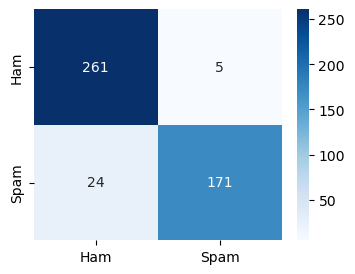

We got 93.71% accuracy


In [47]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
print(f"We got {round(test_score*100, 2)}% accuracy")

In [48]:
y_pred = pd.DataFrame(y_pred, columns=['Prediction'])

y_pred['Prediction'] = y_pred['Prediction'].map({1: 'spam', 0: 'ham'})
y_pred.tail(10)

,Prediction
451,ham
452,ham
453,spam
454,ham
455,ham
456,spam
457,spam
458,spam
459,spam
460,spam


In [49]:
y_test = pd.DataFrame(y_test, columns=['Actual Detection'])
y_test['Actual Detection'] = y_test['Actual Detection'].map({1: 'spam', 0: 'ham'})
y_test.head()

,Actual Detection
0,ham
1,ham
2,ham
3,spam
4,ham


### Prediction DataFrame

In [50]:
pred_df = pd.concat([y_test, y_pred.reset_index(drop=True)], axis=1)
pred_df.tail(10)

,Actual Detection,Prediction
451,ham,ham
452,ham,ham
453,spam,spam
454,ham,ham
455,ham,ham
456,spam,spam
457,spam,spam
458,spam,spam
459,spam,spam
460,spam,spam


**Randomly selecting indices to get better insights about the predictions**

In [51]:
random_indices = np.random.choice(len(y_test), size=10, replace=False)
# y_test.shape
pred_df.iloc[random_indices]

,Actual Detection,Prediction
167,spam,ham
372,ham,ham
367,ham,ham
149,spam,spam
259,ham,ham
9,ham,ham
3,spam,ham
361,spam,spam
67,ham,ham
20,ham,ham
